In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle



    Only loading the 'en' tokenizer.



## Language modeling

### Data

In [2]:
PATH='data/spookyauthoriden/'

In [3]:
!ls {PATH}

all	sample_submission.csv  test	 test.txt  train      train.txt
models	subm_spooky.csv        test.csv  tmp	   train.csv  valid


In [14]:
!ls {PATH}train

EAP  HPL  MWS


In [6]:
TRN_PATH = 'train/'
VAL_PATH = 'valid/'
TST_PATH = 'test/'
TRN = f'{PATH}all/{TRN_PATH}'
VAL = f'{PATH}all/{VAL_PATH}'
TST = f'{PATH}{TST_PATH}'

In [3]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [4]:
bs=64; bptt=70

In [7]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=TST_PATH)

In [7]:
%time md = LanguageModelData.from_text_files(f'{PATH}all/', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

CPU times: user 12.8 s, sys: 1.62 s, total: 14.4 s
Wall time: 37.1 s


In [9]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT_fromfiles.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [9]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(108, 4154, 1, 492480)

This is the start of the mapping from integer IDs to unique tokens.

### Train

In [8]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [9]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [10]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [25]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▎| 101/108 [00:16<00:01,  6.03it/s, loss=27.4]

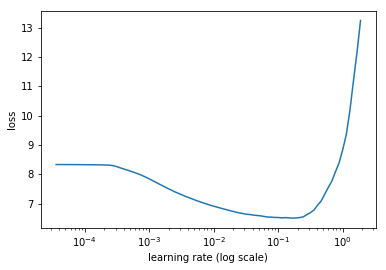

In [26]:
learner.sched.plot()

In [11]:
lr = 1e-2

In [16]:
%time learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='learner_c1')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.70252  5.54807]                                
[ 1.       5.65496  5.59013]                                
[ 2.       5.61669  5.52986]                                
[ 3.       5.65292  5.86278]                                
[ 4.       5.34726  5.01431]                                
[ 5.       4.9975   4.82116]                                
[ 6.       4.86201  4.76808]                                
[ 7.       4.83463  4.67471]                                
[ 8.       4.69903  4.59231]                                
[ 9.       4.59831  4.50923]                                
[ 10.       4.5175   4.4479]                                
[ 11.        4.45623   4.40971]                             
[ 12.        4.40191   4.38304]                             
[ 13.        4.37095   4.36671]                             
[ 14.        4.34382   4.36263]                             

CPU times: user 3min 40s, sys: 45.4 s, total: 4min 25s
Wall time: 4min 21s


In [17]:
learner.save('learner_c1')

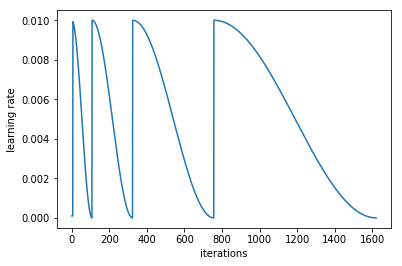

In [18]:
learner.sched.plot_lr()

In [17]:
%time learner.fit(lr, 5, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='learner_c2')

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[ 0.       4.38319  4.34605]                                
[ 1.       4.37966  4.32682]                                
[ 2.       4.27711  4.2854 ]                                
[ 3.       4.29854  4.27436]                               
[ 4.       4.22901  4.23895]                                
[ 5.       4.13906  4.2039 ]                                
[ 6.       4.07391  4.19797]                                
[ 7.       4.154    4.21978]                                
[ 8.       4.10991  4.20588]                                
[ 9.       4.04754  4.18966]                                
[ 10.        3.99096   4.17497]                             
[ 11.        3.92945   4.1647 ]                             
[ 12.        3.867     4.16591]                             
[ 13.        3.84398   4.15977]                             
[ 14.        3.81494   4.16057]                             
[ 15.        3.93758   4.19135]                             
[ 16.        3.93235   4.

In [18]:
learner.save('learner_c2')

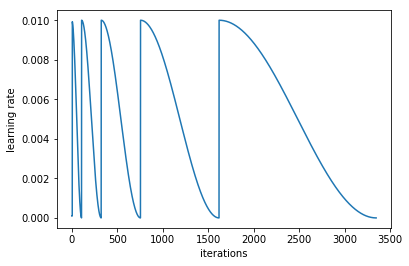

In [19]:
learner.sched.plot_lr()

In [13]:
learner.load_cycle('learner_c2', 1)

In [14]:
learner.save_encoder('learner_c2_encoder')

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [15]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

". So , it was n't quite was I was expecting , but I really liked it anyway ! The best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [16]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [17]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

[',', '.', '<unk>', '?', ';', 'to', 'of', 'in', '"', 'and']

...and let's see if our model can generate a bit more text all by itself!

In [18]:
print(ss,"\n")
for i in range(70):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

, and the most terrible , and the most more than a man , and the most more than the most of the world . <eos> the old man was not a little , and the most more than the most more than the most more than the most of the world . <eos> the old man was not a little , and the most more than the most more ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [10]:
TEXT = pickle.load(open(f'{PATH}models/TEXT_fromfiles.pkl','rb'))

In [11]:
LABEL = data.Field(sequential=False)

In [12]:
class PredictAuthorDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['EAP', 'HPL', 'MWS']:
            for fname in iglob(os.path.join(path, label, '*.txt')):
                with open(fname, 'r') as f: text = f.readline()
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', valid=None ,**kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=valid, test=test, **kwargs)

In [28]:
!ls {PATH}

all	sample_submission.csv  test	 test.txt  train      train.txt
models	subm_spooky.csv        test.csv  tmp	   train.csv  valid


In [35]:
#splits = PredictAuthorDataset.splits(TEXT, LABEL, PATH, train='train', test='valid')

In [13]:
splits = PredictAuthorDataset.splits(TEXT, LABEL, PATH, train='train', test='valid')

In [14]:
len(splits[0].examples), len(splits[1].examples)

(15663, 3916)

In [37]:
splits[2].examples[1].text

['we',
 'demand',
 'at',
 'once',
 ',',
 'and',
 'very',
 'naturally',
 ',',
 'why',
 '?']

In [15]:
md2 = TextData.from_splits(PATH, splits, bs)

In [73]:
md2.test_ds

AttributeError: 'TextDataLoader' object has no attribute 'dataset'

In [39]:
md2

In [16]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'learner_c2_encoder')

In [82]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.2, dropouti=0.8, wdrop=1.0, dropoute=0.1, dropouth=0.6)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'learner_c2_encoder')

In [17]:
m3.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▍  | 182/244 [00:13<00:04, 13.09it/s, loss=4.99]

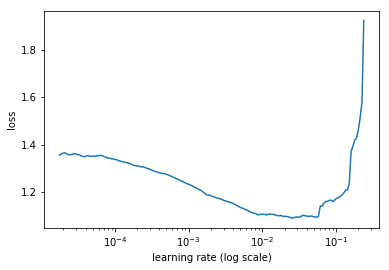

 75%|███████▍  | 182/244 [00:30<00:10,  6.05it/s, loss=4.99]

In [18]:
m3.sched.plot()

In [19]:
m3.clip=25.
lrs=np.array([5e-4,5e-3,5e-2])

In [85]:
#m3.clip=25.
#lrs=np.array([5e-5,5e-4,5e-3])

In [20]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))


 32%|███▏      | 79/244 [00:02<00:04, 38.52it/s, loss=1.06]

 34%|███▍      | 84/244 [00:02<00:04, 38.48it/s, loss=1.06] [A

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError:

[ 0.       1.0754   0.94014  0.52946]                       



In [21]:
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.84686  0.73976  0.68289]                        



In [47]:
#m3.save('author_c1')

In [22]:
m3.save('author_c1_withouttest2')

In [23]:
%time m3.fit(lrs, 4, metrics=[accuracy], cycle_len=1, cycle_save_name='author_c2_withouttest2')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.75795  0.67726  0.71978]                        
[ 1.       0.7151   0.64176  0.7313 ]                        
[ 2.       0.66299  0.60362  0.7459 ]                        
[ 3.       0.61921  0.56859  0.76614]                        

CPU times: user 1min 4s, sys: 10.6 s, total: 1min 15s
Wall time: 1min 13s


In [49]:
#m3.save('author_c2')

In [77]:
m3.save('author_c2_withouttest2')

In [25]:
%time m3.fit(lrs, 3, metrics=[accuracy], cycle_len=1, cycle_mult=2, cycle_save_name='author_c3_withouttest2')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.40652  0.43993  0.82838]                        
[ 1.       0.47937  0.4807   0.81916]                        
[ 2.       0.36281  0.43829  0.82403]                        
[ 3.       0.48106  0.43761  0.82223]                        
[ 4.       0.4092   0.48368  0.81455]                        
[ 5.       0.33776  0.44594  0.83402]                        
[ 6.       0.29544  0.44789  0.83197]                        

CPU times: user 1min 57s, sys: 18.2 s, total: 2min 15s
Wall time: 2min 12s


In [51]:
#m3.save('author_c3')

In [51]:
#m3.save('author_c3_withouttest')

In [26]:
m3.load_cycle('author_c3_withouttest2',0)

In [27]:
%time m3.fit(lrs, 3, metrics=[accuracy], cycle_len=1, cycle_save_name='author_c3_withouttest3')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.40155  0.45024  0.82812]                        
[ 1.       0.39827  0.45342  0.82556]                        
[ 2.       0.39705  0.43969  0.8271 ]                        

CPU times: user 48.7 s, sys: 8.1 s, total: 56.8 s
Wall time: 55.5 s


In [28]:
m3.save('author_c3_withouttest3')

In [29]:
m3.load_cycle('author_c3_withouttest2',0)

In [30]:
%time m3.fit(lrs, 2, metrics=[accuracy], cycle_len=2, cycle_save_name='author_c3_withouttest4')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.46143  0.4404   0.82018]                        
[ 1.       0.378    0.44407  0.82889]                        
[ 2.       0.44257  0.50079  0.80712]                        
[ 3.       0.34968  0.45291  0.83094]                        

CPU times: user 1min 5s, sys: 10.4 s, total: 1min 16s
Wall time: 1min 14s


In [31]:
m3.save('author_c3_withouttest4')

In [32]:
m3.load_cycle('author_c3_withouttest2',0)

In [33]:
accuracy(*m3.predict_with_targs())

0.82838114754098358

In [54]:
x = m3.predict_with_targs(True)

In [87]:
x = x[0][:,1:]

In [88]:
x.shape

(8384, 3)

In [105]:
y = np.apply_over_axes(np.sum, np.exp(x), 1)

In [109]:
df_test = pd.read_csv(f'{PATH}test.csv')

In [110]:
preds = np.exp(x)/y
df_subm = pd.DataFrame(preds)
df_subm.columns = ['EAP', 'HPL', 'MWS']
df_id = df_test.drop('text', axis = 1)
df_result = pd.concat([df_id, df_subm], axis =1 , join ='inner')

In [62]:
preds =to_np(F.softmax(torch.from_numpy(pre_preds[:,1:])))
df_subm = pd.DataFrame(preds)
df_subm.columns = ['EAP', 'HPL', 'MWS']
df_id = df_test.drop('text', axis = 1)
df_result = pd.concat([df_id, df_subm], axis =1 , join ='inner')

TypeError: 'NoneType' object is not iterable

In [111]:
df_result.to_csv(f'{PATH}subm_spooky.csv', index_label=None)
FileLink(f'{PATH}subm_spooky.csv')

/home/ubuntu/fastai/courses/dl1/data/spookyauthoriden/subm_spooky.csv

In [112]:
df_result.head()

,id,EAP,HPL,MWS
0,id02310,0.991728,0.002400,0.005872
1,id24541,0.712429,0.136957,0.150613
2,id00134,0.975670,0.004931,0.019399
3,id27757,0.366603,0.581197,0.052200
4,id04081,0.661212,0.225047,0.113742


In [36]:
#Predict

In [38]:
!ls {PATH}

all	sample_submission.csv  test	 test.txt  train      train.txt
models	subm_spooky.csv        test.csv  tmp	   train.csv  valid


In [34]:
tst = pd.read_csv(f'{PATH}test.csv')

In [35]:
tst.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [36]:
tst.values[:,1].shape[0]

8392

In [38]:
m = m3.model

In [39]:
m[0].bs = 1

In [40]:
tst["text"][0]

'Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield.'

In [41]:
tst["text"][8391]

'Long winded, statistical, and drearily genealogical as some of the matter was, there ran through it a continuous thread of brooding, tenacious horror and preternatural malevolence which impressed me even more than it had impressed the good doctor.'

In [42]:
ss = tst["text"][0]
s = [spacy_tok(ss)]
t = TEXT.numericalize(s)

In [43]:
m.eval()
m.reset()
res,*_ = m(t)

In [44]:
res[-1]

Variable containing:
-35.1963
 -0.8630
  1.9080
 -1.7858
[torch.cuda.FloatTensor of size 4 (GPU 0)]

In [45]:
torch.topk(res[-1], 1)

(Variable containing:
  1.9080
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  2
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [55]:
to_np(torch.topk(res[-1], 1)[1])[0]

2

In [56]:
LABEL.vocab.itos[2]

'MWS'

In [57]:
LABEL.vocab.itos[to_np(torch.topk(res[-1], 1)[1])[0]]

'MWS'

In [76]:
to_np(torch.topk(res[-1], 3)[0])

array([ 1.90804, -0.86297, -1.7858 ], dtype=float32)

In [77]:
to_np(torch.topk(res[-1], 3)[1])

array([2, 1, 3])

In [83]:
for i in to_np(torch.topk(res[-1], 3)[1]):
    print(LABEL.vocab.itos[i])

MWS
EAP
HPL


In [79]:
sum(np.exp(to_np(torch.topk(res[-1], 3)[0])))

7.3294236660003662

In [80]:
np.exp(to_np(torch.topk(res[-1], 3)[0]))/sum(np.exp(to_np(torch.topk(res[-1], 3)[0])))

array([ 0.91956,  0.05756,  0.02288], dtype=float32)

In [72]:
F.softmax(np.exp(to_np(torch.topk(res[-1], 3)[0])))

KeyError: <class 'numpy.ndarray'>

In [93]:
labels = dict()

In [96]:
for i in range(1,4):
    labels[i] = LABEL.vocab.itos[i]
    print(LABEL.vocab.itos[i])
    
labels

EAP
MWS
HPL


{1: 'EAP', 2: 'MWS', 3: 'HPL'}

In [108]:
def get_authors(x):
    authors_values = []
    for i in x:
        authors_values.append(labels[i])
    return authors_values

In [109]:
get_author([2, 1, 3])

['MWS', 'EAP', 'HPL']

In [142]:
def get_probs(x):
    return np.exp(x)/sum(np.exp(x))

In [143]:
subm = pd.DataFrame([],
...                    columns=['EAP', 'HPL', 'MWS'])

In [144]:
subm

,EAP,HPL,MWS


In [118]:
sv = np.exp(to_np(torch.topk(res[-1], 3)[0]))/sum(np.exp(to_np(torch.topk(res[-1], 3)[0])))

In [122]:
df = pd.DataFrame([list(sv)], columns=get_author([2, 1, 3]))

In [124]:
sv, get_author([2, 1, 3])

(array([ 0.91956,  0.05756,  0.02288], dtype=float32), ['MWS', 'EAP', 'HPL'])

In [123]:
df

,MWS,EAP,HPL
0,0.919561,0.057563,0.022875


In [130]:
subm = subm.append(df)

In [137]:
subm

,EAP,HPL,MWS


In [145]:
for i in range(tst.values[:,1].shape[0]):
    ss = tst["text"][i] #Actual text review
    s = [spacy_tok(ss)]
    t = TEXT.numericalize(s)
   
    m.eval()
    m.reset()
    res,*_ = m(t)
    
    #predict
    preds = to_np(torch.topk(res[-1], 3)[0])
    #softmax
    probs = get_probs(preds)
    
    #authors index
    labels_idx = to_np(torch.topk(res[-1], 3)[1])
    #authors
    preds_authors = get_authors(labels_idx)
    
    #process
    df = pd.DataFrame([list(probs)], columns=preds_authors)
    
    #Add
    subm = subm.append(df)

In [146]:
subm.head()

,EAP,HPL,MWS
0,0.057563,0.022875,0.919561
0,0.997866,0.000817,0.001317
0,0.001454,0.996716,0.001830
0,0.981089,0.007868,0.011043
0,0.839752,0.095541,0.064706


In [141]:
probs

array([-0.74435, -0.304  ,  2.04835], dtype=float32)

In [ ]:
df_id = tst.drop('text', axis = 1)

In [152]:
df_id.head()

,id
0,id02310
1,id24541
2,id00134
3,id27757
4,id04081


In [156]:
df_id = tst.drop('text', axis = 1)
df_result = pd.concat([df_id, subm], axis =1 , join ='inner')

In [157]:
df_result.head()

,id,EAP,HPL,MWS
0,id02310,0.057563,0.022875,0.919561
0,id02310,0.997866,0.000817,0.001317
0,id02310,0.001454,0.996716,0.001830
0,id02310,0.981089,0.007868,0.011043
0,id02310,0.839752,0.095541,0.064706


In [ ]:
df_result.to_csv(f'{PATH}subm_spooky_k.csv')

In [151]:
FileLink(f'{PATH}subm_spooky_k.csv')

/home/ubuntu/fastai/courses/dl1/data/spookyauthoriden/subm_spooky_k.csv

### End

In [55]:
pd.read_csv(f'{PATH}sample_submission.csv').head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698
